In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 6.21 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [ ]:
import pandas as pd
df = pd.read_csv('german-traffic-signs/signnames.csv')
df.head(5)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import pandas as pd
import cv2

## Load Train, Test and Validation dataset

In [ ]:
np.random.seed(0)
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    valid_data = pickle.load(f)

In [ ]:
train_x, train_y = train_data['features'],train_data['labels']
val_x, val_y = valid_data['features'],valid_data['labels']
test_x,test_y = test_data['features'],test_data['labels']

print('Train data shape',train_x.shape,'Train data label',train_y.shape)
print('Test data shape',test_x.shape,'Test data label',test_y.shape)
print('valid data shape',val_x.shape,'Valid data label',val_y.shape)

Train data shape (34799, 32, 32, 3) Train data label (34799,)
Test data shape (12630, 32, 32, 3) Test data label (12630,)
valid data shape (4410, 32, 32, 3) Valid data label (4410,)


## getting number of samples from each class in training dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
num_samples = []
for i in range(len(df)):
    file_count = len(os.listdir('/content/drive/MyDrive/Train/'+str(i)+'/'))
    num_samples.append(file_count)
print(len(num_samples))

43


In [ ]:
print(num_samples)

[0, 0, 2260, 1410, 1990, 1870, 420, 1440, 1410, 1470, 0, 702, 2110, 2200, 780, 630, 430, 1120, 1210, 210, 380, 330, 390, 510, 270, 1500, 600, 240, 540, 270, 450, 780, 240, 699, 420, 1200, 390, 210, 2100, 300, 360, 240, 240]


## Plot the distribution of the number of samples from each class in training dataset

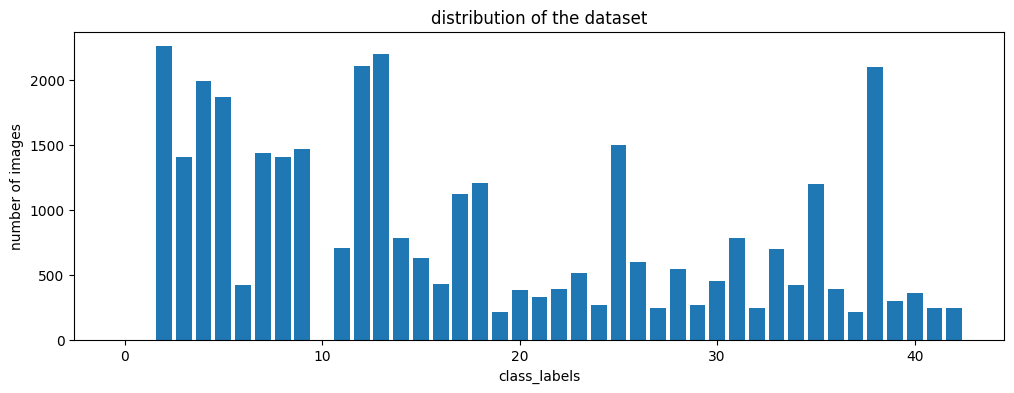

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(range(0, len(df)), num_samples)
plt.title('distribution of the dataset')
plt.xlabel('class_labels')
plt.ylabel('number of images')
plt.show()

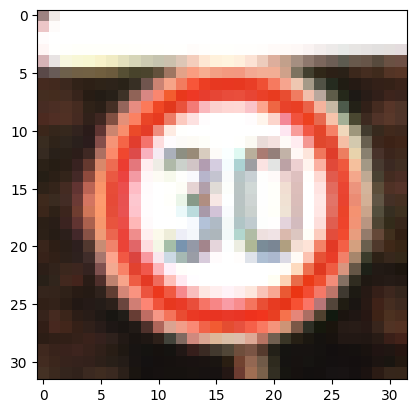

In [ ]:
plt.imshow(train_x[3000])

## Convert the image to grayscale
#### Note: Reason to convert to grayscale is, for traffic sign identification, color is not necessary, only edges and shapes are required

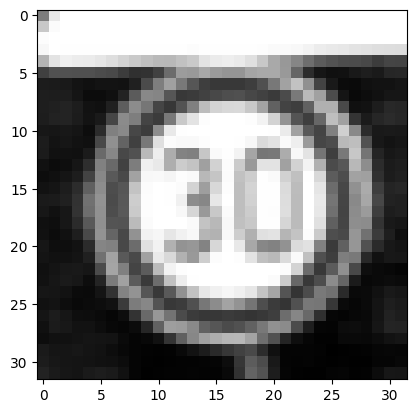

In [ ]:
def grayscale(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

img = grayscale(train_x[3000])
plt.imshow(img, cmap = plt.get_cmap('gray'))

### Use histogram equalization technique to standardize contrast/light in all images

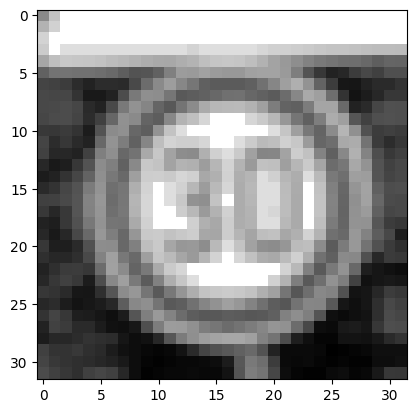

In [ ]:
def equalize(image):
    image = cv2.equalizeHist(image)
    return image
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
def processing(image):
    gray_img = grayscale(image)
    img = equalize(gray_img)
    img = img/255
    return img

## Convert all train, test and validation dataset to grayscale & histogram technique

In [ ]:
train_x = np.asarray(list(map(processing, train_x)))
val_x = np.asarray(list(map(processing, val_x)))
test_x = np.asarray(list(map(processing, test_x)))

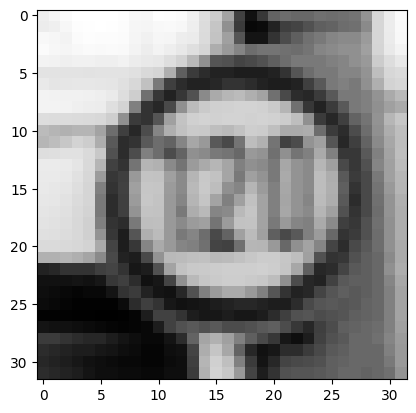

In [ ]:
plt.imshow(train_x[random.randint(0, len(train_x-1))],cmap=plt.get_cmap('gray'))

In [ ]:
train_x.shape[0]

34799

In [ ]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
val_x = val_x.reshape(val_x.shape[0],val_x.shape[1],val_x.shape[2],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)


## Generate some datasets with different angles using Keras Imagedatagenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(train_x)
#batches = datagen.flow(train_x,train_y,batch_size=15)


## One-hot encode the labels

In [ ]:
train_y = to_categorical(train_y,43)
test_y = to_categorical(test_y,43)
val_y = to_categorical(val_y,43)

## Define the model

In [ ]:
# Build and train the CNN

import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=input_shape))
    model.add(ReLU())
    model.add(Conv2D(60, (5, 5)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3)))
    model.add(ReLU())
    model.add(Conv2D(30, (3, 3)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
batch_size = 64
steps_per_epoch = 20  # You can set this to 20 or any other value you prefer

cnn_model = build_cnn_model(train_x.shape[1:], len(df['ClassId']))
history = cnn_model.fit(train_x, train_y, batch_size=batch_size, epochs=15, validation_data=(val_x, val_y), shuffle=1, steps_per_epoch=steps_per_epoch)


Epoch 1/15
20/20 [==============================] - 37s 2s/step - loss: 3.6044 - accuracy: 0.0586 - val_loss: 3.5402 - val_accuracy: 0.0544
Epoch 2/15
20/20 [==============================] - 33s 2s/step - loss: 3.4924 - accuracy: 0.0789 - val_loss: 3.4665 - val_accuracy: 0.1041
Epoch 3/15
20/20 [==============================] - 27s 1s/step - loss: 3.2305 - accuracy: 0.1633 - val_loss: 2.8997 - val_accuracy: 0.2692
Epoch 4/15
20/20 [==============================] - 34s 2s/step - loss: 2.4362 - accuracy: 0.3703 - val_loss: 2.0456 - val_accuracy: 0.4694
Epoch 5/15
20/20 [==============================] - 34s 2s/step - loss: 1.8457 - accuracy: 0.4914 - val_loss: 1.4267 - val_accuracy: 0.6036
Epoch 6/15
20/20 [==============================] - 34s 2s/step - loss: 1.4542 - accuracy: 0.5797 - val_loss: 1.1655 - val_accuracy: 0.6803
Epoch 7/15
20/20 [==============================] - 37s 2s/step - loss: 1.1842 - accuracy: 0.6516 - val_loss: 0.8826 - val_accuracy: 0.7542
Epoch 8/15
20/20 [==

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Extract features from the CNN model
cnn_features = cnn_model.predict(train_x)

1088/1088 [==============================] - 111s 102ms/step


In [ ]:
# Train a Decision Tree on the extracted features
decision_tree = DecisionTreeClassifier()
decision_tree.fit(cnn_features, np.argmax(train_y, axis=1))

DecisionTreeClassifier()

In [ ]:
# Evaluate the Decision Tree model
cnn_val_features = cnn_model.predict(val_x)
accuracy = decision_tree.score(cnn_val_features, np.argmax(val_y, axis=1))
print(f"Decision Tree Accuracy: {accuracy}")

138/138 [==============================] - 14s 103ms/step
Decision Tree Accuracy: 0.8945578231292517


## Train the model

###### able to achieve 92% accuracy

Text(0, 0.5, 'loss')

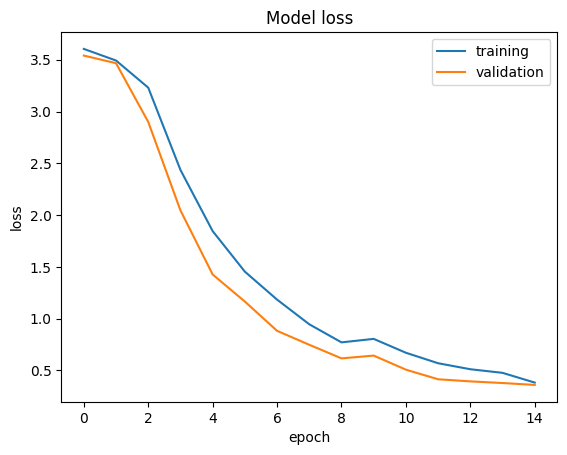

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

## Evaluate the model with test data

In [ ]:
score = cnn_model.evaluate(test_x, test_y , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.4649265706539154
The Accuracy score is:  0.8748218417167664


### Testing the model using an external traffic sign image

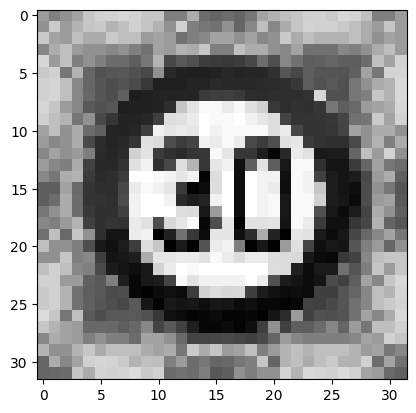

1/1 [==============================] - 0s 121ms/step
The traffic sign is Speed limit (30km/h)


In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your image as you've done before
img = Image.open('/test2.jpeg')
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
# plt.imshow(img)
# plt.show()
# Assuming 'processing' is a function you've defined to preprocess the image
img = processing(img)

# Display the preprocessed image
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

# Reshape the image for prediction
img = img.reshape(1, 32, 32, 1)

# Use the model to predict class probabilities
class_probabilities = cnn_model.predict(img)

# Find the class with the highest probability
predicted_class = np.argmax(class_probabilities)

# Assuming 'df' contains class labels, you can print the predicted class label
#print('Predicted class is', predicted_class)
print('The traffic sign is', df['SignName'][predicted_class])
